In [17]:
import sys
from helper import preprocess_runs

path_name_dict = {
    'JOB-Light': 'JOB-light.json',
    'JOB': 'JOB.json',
    'JOB-Complex': 'JOB-Complex.json'
}
benchmark_stats_dict = preprocess_runs(json_path='plans_dataset',path_name_dict=path_name_dict)

Loading run files from plans_dataset
Benchmark: JOB-Light (140 plans)


Cleaning SQL: 100%|██████████| 140/140 [00:00<00:00, 410631.16it/s]


Benchmark: JOB (37085 plans)


Cleaning SQL: 100%|██████████| 37085/37085 [00:00<00:00, 456713.81it/s]


Benchmark: JOB-Complex (18479 plans)


Cleaning SQL: 100%|██████████| 18479/18479 [00:00<00:00, 500345.65it/s]


In [ ]:
import hashlib
import os
import json
from typing import Dict
from cleanup_sql import cleanup_sql

def normalize_sql(sql: str) -> str:
    """
    Consistently cleans and normalizes an SQL query string.
    - Converts to lowercase.
    - Removes leading/trailing whitespace.
    - Removes a trailing semicolon if it exists.
    - Collapses all internal whitespace (spaces, tabs, newlines) into single spaces.
    """
    normalized = sql.lower()
    normalized = normalized.strip()
    if normalized.endswith(';'):
        normalized = normalized[:-1]
    return ' '.join(normalized.split())

def load_named_queries_from_dir(query_dir: str) -> Dict[str, str]:
    """
    Load and clean all .sql queries from a directory.
    Returns a mapping: cleaned_sql -> query_name (filename without .sql)
    """
    name_map = {}
    for fname in os.listdir(query_dir):
        if not fname.endswith('.sql'):
            continue
        fpath = os.path.join(query_dir, fname)
        with open(fpath, 'r') as f:
            raw_sql = f.read()
        # Escape the last newline character if it exists
        raw_sql = raw_sql.rstrip('\n')
        normalized_sql = normalize_sql(raw_sql)
        query_name = os.path.splitext(fname)[0]
        name_map[normalized_sql] = query_name
    return name_map

def write_query_data(output_root: str, benchmark_stats_dict: Dict, query_name_dirs: Dict[str, str]):
    os.makedirs(output_root, exist_ok=True)

    # Load all query name maps from provided directories
    query_name_maps = {
        benchmark: load_named_queries_from_dir(path)
        for benchmark, path in query_name_dirs.items()
    }
    
    print(f"Loaded query name maps: {query_name_maps}")

    for benchmark_name, plan_info_dict in benchmark_stats_dict.items():
        print(f"Processing benchmark: {benchmark_name}")
        benchmark_dir = os.path.join(output_root, benchmark_name.lower().replace('-', '_'))
        os.makedirs(benchmark_dir, exist_ok=True)

        name_map = query_name_maps.get(benchmark_name, {})
        unnamed_counter = 1

        for cleaned_sql, sql_info in plan_info_dict.items():
            normalized_sql = normalize_sql(cleaned_sql)
            found_named_query = False
            for raw_sql, query_name in name_map.items():
                if normalized_sql == raw_sql:
                    found_named_query = True
                    query_dirname = query_name
                    # remove the query name from the map to avoid duplicates
                    del name_map[raw_sql]
                    break
            
            if not found_named_query:
                if benchmark_name == 'JOB':
                    print(f"Did not find named query for cleaned SQL: {cleaned_sql}")
                    for raw_sql, query_name in name_map.items():
                        print(f"Checked against raw_sql: {raw_sql}")
                query_dirname = f'q{unnamed_counter}'
                unnamed_counter += 1

            query_dir = os.path.join(benchmark_dir, query_dirname)
            os.makedirs(query_dir, exist_ok=True)

            # Save query
            with open(os.path.join(query_dir, f'{query_dirname}.sql'), 'w') as f:
                f.write(cleaned_sql)

            # Save optimal plan
            with open(os.path.join(query_dir, f'{query_dirname}_optimal_plan.json'), 'w') as f:
                json.dump(sql_info.get('opt_plan', {}), f, indent=2)

            # Save metadata
            metadata = {
                'pg_runtime': sql_info.get('pg_runtime'),
                'opt_runtime': sql_info.get('opt_runtime'),
                'pg_slowdown': sql_info.get('pg_slowdown'),
                'pg_opt_diff': sql_info.get('pg_opt_diff'),
                'original_num_of_plans': sql_info.get('num_plans'),
                'pg_plan_card_error': sql_info.get('pg_plan_card_error'),
                'opt_plan_card_error': sql_info.get('opt_plan_card_error'),
                'num_tables': sql_info.get('num_tables'),
                'opt_hint': sql_info.get('opt_hint'),
            }
            with open(os.path.join(query_dir, f'{query_dirname}_metadata.json'), 'w') as f:
                json.dump(metadata, f, indent=2)

from pathlib import Path
try:
    # Works when running from a .py file
    REPO_ROOT = Path(__file__).resolve()
except NameError:
    # Fallback for notebooks — use current working directory
    REPO_ROOT = Path.cwd().resolve()
while REPO_ROOT.name != "Learned-Optimizers-Benchmarking-Suite" and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent

query_name_dirs = {
    'JOB': f'{REPO_ROOT}/workloads/imdb_pg_dataset/job/',
    'JOB-Light': f'{REPO_ROOT}/workloads/imdb_pg_dataset/job_light/',
    # JOB-Complex handled with counter
}

write_query_data(
    output_root='.',
    benchmark_stats_dict=benchmark_stats_dict,
    query_name_dirs=query_name_dirs
)

Loaded query name maps: {'JOB': {"select min(mi.info) as movie_budget, min(mi_idx.info) as movie_votes, min(n.name) as writer, min(t.title) as violent_liongate_movie from cast_info as ci, company_name as cn, info_type as it1, info_type as it2, keyword as k, movie_companies as mc, movie_info as mi, movie_info_idx as mi_idx, movie_keyword as mk, name as n, title as t where ci.note in ('(writer)', '(head writer)', '(written by)', '(story)', '(story editor)') and cn.name like 'lionsgate%' and it1.info = 'genres' and it2.info = 'votes' and k.keyword in ('murder', 'violence', 'blood', 'gore', 'death', 'female-nudity', 'hospital') and mi.info in ('horror', 'action', 'sci-fi', 'thriller', 'crime', 'war') and t.id = mi.movie_id and t.id = mi_idx.movie_id and t.id = ci.movie_id and t.id = mk.movie_id and t.id = mc.movie_id and ci.movie_id = mi.movie_id and ci.movie_id = mi_idx.movie_id and ci.movie_id = mk.movie_id and ci.movie_id = mc.movie_id and mi.movie_id = mi_idx.movie_id and mi.movie_id =

70
113
30
Benchmark      Num Queries    Total Opt Runtime (s)    Total PG Runtime (s)    Total Speedup    Median Speedup    Median Diff (s)    PG Best Plan Selected (%)    Speedup 90th percentile
-----------  -------------  -----------------------  ----------------------  ---------------  ----------------  -----------------  ---------------------------  -------------------------
JOB-Light               70                  2359.72                 2795.53             1.18           1.00208               0.51                        40                       1.45408
JOB                    113                   156.79                  312.23             1.99           1.28699              88                            8.85                    5.11035
JOB-Complex             30                    54.17                  567.01            10.47           8.50421           10654.2                          0                      83.6684


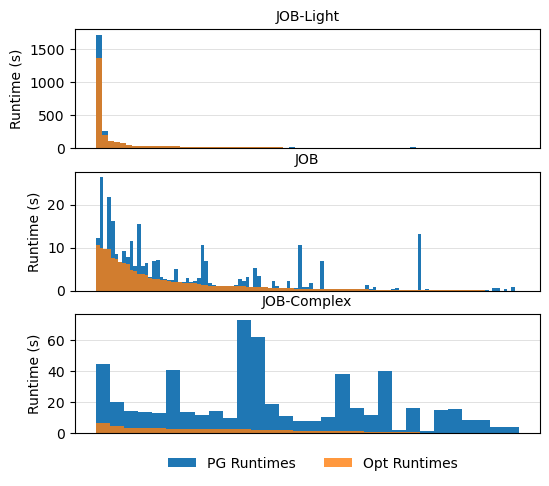

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


def create_runtime_plot(df, benchmark_name: str, max=None, ax=None, show_legend=True, bbox_to_anchor=None):
    opt_runtimes = df['optimal']
    pg_runtimes = df['pg']
    q_ids = df['q_id']

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    sorted_opt_runtimes = sorted(opt_runtimes, reverse=True)
    sorted_pg_runtimes = [x for _, x in sorted(zip(opt_runtimes, pg_runtimes), reverse=True)]
    sorted_qids = [str(x) for _, x in sorted(zip(opt_runtimes, q_ids), reverse=True)]

    ax.bar(sorted_qids, sorted_pg_runtimes, label='PG Runtimes', width=1)
    ax.bar(sorted_qids, sorted_opt_runtimes, label='Opt Runtimes', alpha=0.8, width=1)
    # plt.title(f'Opt / PG Runtimes ({benchmark_name})')
    if show_legend:
        ax.legend(frameon=False, loc='upper right', bbox_to_anchor=bbox_to_anchor, ncols=2)

    ax.set_title(f'{benchmark_name}', fontsize=10)
    ax.set_ylabel('Runtime (s)')

    # hide xtick labels
    ax.set_xticks([])

    if max is not None:
        ax.set_ylim(0, max)

    ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.7)
    ax.set_axisbelow(True)


fig, axs = plt.subplots(len(benchmark_stats_dict), 1, figsize=(6, 1.75 * len(benchmark_stats_dict)))

cleanup_pg_opt_mismatch = True

tabulate_list = []
id_to_sql_dict = defaultdict(dict)
for i, (benchmark_name, info) in enumerate(benchmark_stats_dict.items()):
    optimal_runtimes = []
    pg_runtimes = []
    q_ids = []
    speedup_list = []
    diff_list = []
    pg_best_plan_selected = []

    for id, (sql, plan_info) in enumerate(info.items()):
        opt_rt = plan_info['opt_runtime']
        pg_rt = plan_info['pg_runtime']

        if opt_rt is None or pg_rt is None:
            print(f'Skip because of null: {opt_rt} / {pg_rt}')
            continue

        # convert to seconds
        opt_rt = opt_rt / 1000
        pg_rt = pg_rt / 1000

        if cleanup_pg_opt_mismatch and opt_rt > pg_rt:
            opt_rt = pg_rt

        q_ids.append(id)
        optimal_runtimes.append(opt_rt)
        pg_runtimes.append(pg_rt)
        id_to_sql_dict[benchmark_name][id] = (sql, opt_rt, pg_rt, plan_info['opt_hint'])

        speedup_list.append(plan_info['pg_slowdown'])
        diff_list.append(plan_info['pg_opt_diff'])

        pg_best_plan_selected.append(opt_rt == pg_rt)

    # convert to df (two columns)
    df = pd.DataFrame({'optimal': optimal_runtimes, 'pg': pg_runtimes, 'q_id': q_ids,
                       'speedup': speedup_list, 'diff': diff_list})
    print(len(optimal_runtimes))

    # add to list
    tabulate_list.append([benchmark_name, len(info), f"{sum(df['optimal']):.2f}", f"{sum(df['pg']):.2f}",
                          f"{sum(df['pg']) / sum(df['optimal']):.2f}", f"{np.median(df['speedup'])}",
                          f"{np.median(df['diff']):.2f}",
                          f'{sum(pg_best_plan_selected) / len(pg_best_plan_selected) * 100:.2f}',
                          np.percentile(df['speedup'], 90)])

    create_runtime_plot(df, benchmark_name=benchmark_name, max=None, ax=axs[i], show_legend=i == 2,
                        bbox_to_anchor=(0.85, -.09))

import tabulate

print(tabulate.tabulate(tabulate_list,
                        headers=['Benchmark', 'Num Queries', 'Total Opt Runtime (s)', 'Total PG Runtime (s)',
                                 'Total Speedup', 'Median Speedup', 'Median Diff (s)', 'PG Best Plan Selected (%)',
                                 'Speedup 90th percentile']))